In [30]:
import numpy as np
import pandas as pd 
import os 
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
parent_dir=os.path.dirname(os.getcwd())
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.units as U


(1, 13, 256, 256)


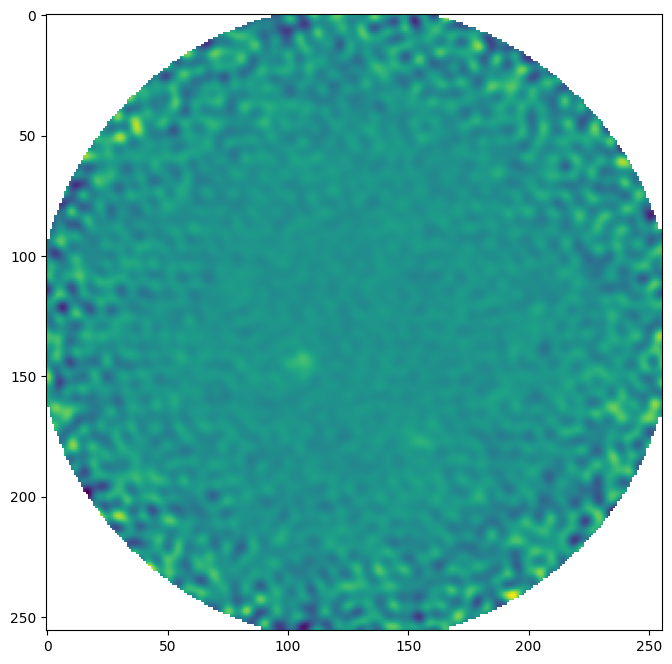

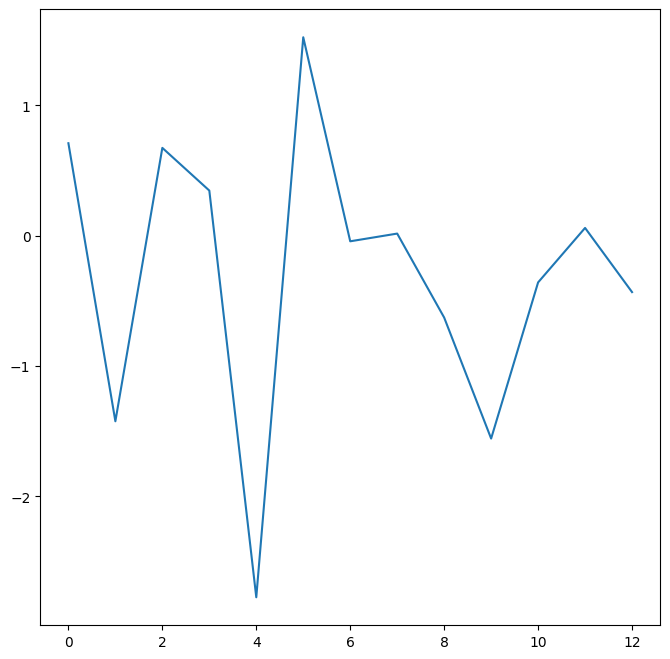

In [45]:
def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

cube, header = load_fits(os.path.join(parent_dir, "member.uid___A001_X2fb_X3ec.J0842p1218_CII.image.pbcor.fits"))
print(cube.shape)
plt.figure(figsize=(8, 8))
plt.imshow(np.sum(cube[0], axis=0))
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(np.arange(cube.shape[1]), np.nansum(cube[0], axis=(1, 2)))
plt.show()



In [21]:
def remove_non_numeric(text):
    """Removes non-numeric characters from a string.
    Args:
        text: The string to process.
    Returns:
        A new string containing only numeric characters and the decimal point (.).
    """
    numbers = "0123456789."
    return "".join(char for char in text if char in numbers)

In [65]:
def freq_supp_extractor(freq_sup):
    freq_band, n_channels, freq_mins, freq_maxs = [], [], [], []
    freq_sup = freq_sup.split('U')
    for i in range(len(freq_sup)):
        sup = freq_sup[i][1:-1].split(',')
        sup = [su.split('..') for su in sup][:2]
        freq_min, freq_max = float(remove_non_numeric(sup[0][0])), float(remove_non_numeric(sup[0][1]))
        freq_d = float(remove_non_numeric(sup[1][0]))
        freq_min = freq_min * U.GHz 
        freq_max = freq_max * U.GHz
        freq_d = freq_d * U.kHz
        freq_d = freq_d.to(U.GHz)
        freq_b = freq_max - freq_min
        n_chan = int(freq_b / freq_d)
        freq_band.append(freq_b)
        n_channels.append(n_chan)
        freq_mins.append(freq_min)
        freq_maxs.append(freq_max)

    return freq_band, n_channels, freq_mins, freq_maxs
metadata = pd.read_csv(os.path.join(parent_dir, "metadata", 'test_qso_metadata.csv'))
folders = ['/Users/michele/qsos/X374', '/Users/michele/qsos/X3ec']
for c, folder in enumerate(folders):
    freq_sup = metadata['Freq.sup.'].values[c]
    freq_band, n_channels, freq_mins, freq_maxs = freq_supp_extractor(freq_sup)
    cube_list = np.sort([file for file in  os.listdir(folder)])
    print(cube_list)
    for i in range(len(freq_band)):
        cube, header = load_fits(os.path.join(folder, cube_list[i]))
        n_chan = cube.shape[1]
        print(n_chan, n_channels[i])

['member.uid___A001_X1273_X374.J1306p0356_sci.spw25.cube.I.pbcor.fits'
 'member.uid___A001_X1273_X374.J1306p0356_sci.spw27.cube.I.pbcor.fits'
 'member.uid___A001_X1273_X374.J1306p0356_sci.spw29.cube.I.pbcor.fits'
 'member.uid___A001_X1273_X374.J1306p0356_sci.spw31.cube.I.pbcor.fits']
958 964
958 964
958 964
958 964
['member.uid___A001_X2fb_X3ec.ari_l.J0842p1218_sci.spw0_269696MHz.12m.cube.I.pbcor.fits'
 'member.uid___A001_X2fb_X3ec.ari_l.J0842p1218_sci.spw1_268007MHz.12m.cube.I.pbcor.fits'
 'member.uid___A001_X2fb_X3ec.ari_l.J0842p1218_sci.spw2_253862MHz.12m.cube.I.pbcor.fits'
 'member.uid___A001_X2fb_X3ec.ari_l.J0842p1218_sci.spw3_251987MHz.12m.cube.I.pbcor.fits']
958 964
958 964
958 969
958 964
